In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.tri as tri

import sparseRRR
from plot_utils import adjust_spines

### Load observed data

In [2]:
M1_25degree = pickle.load(open("data/M1_features.pickle", "rb"))
ephys_features = np.array(M1_25degree["X_o"].columns)[:-4]
Xo = M1_25degree["X_o"].copy()
feature_list = range(23)

In [3]:
prop = pd.read_csv("data/m1_patchseq_meta_data.csv", sep="\t")
prop = prop.rename(columns={"Targeted layer": "Layer"})
prop = prop[["Cell", "Layer", "Cre", "RNA type"]]
prop = prop.set_index("Cell")
prop = prop.reindex(Xo.index)
no_low_qual = np.array(list(map(str, prop["RNA type"].values))) != "nan"
prop = prop.loc[no_low_qual, :]
Xo = Xo.loc[no_low_qual, :]
celltypes = prop["RNA type"]

In [4]:
annotations = pd.read_csv("data/cluster.annotation.csv", index_col=0)
cellTypeColors = {}
for celltype in np.unique(annotations["cluster_label"].values):
    cellTypeColors.update(
        {
            celltype: annotations.iloc[
                np.where(annotations["cluster_label"] == celltype)[0][0], :
            ]["cluster_color"]
        }
    )
colors = np.array([cellTypeColors[celltype] for celltype in celltypes])

In [5]:
model_param_names = np.array(
    [
        "C",
        r"$R_{input}$",
        r"$\tau$",
        r"$g_{Nat}$",
        r"$g_{Na}$",
        r"$g_{Kd}$",
        r"$g_{M}$",
        r"$g_{Kv31}$",
        r"$g_{L}$",
        r"$E_{leak}$",
        r"$\tau_{max}$",
        "VT",
        r"$r_{SS}$",
    ]
)
prior_min = [0.1, 20, 0.1, 0, 0, 0, 0, 0, 0, -130, 50, -90, 0.1]
prior_max = [15, 1000, 70, 250, 100, 30, 3, 250, 3, -50, 4000, -35, 3]

In [6]:
# Vip
celltype_Vip = (
    (celltypes == "Vip C1ql1")
    | (celltypes == "Vip Chat_1")
    | (celltypes == "Vip Gpc3")
    | (celltypes == "Vip Htr1f")
    | (celltypes == "Vip Mybpc1_1")
    | (celltypes == "Vip Mybpc1_2")
    | (celltypes == "Vip Mybpc1_3")
    | (celltypes == "Vip Serpinf1_1")
    | (celltypes == "Vip Serpinf1_2")
    | (celltypes == "Vip Serpinf1_3")
    | (celltypes == "Vip Sncg")
)

# Sst
celltype_Sst = (
    (celltypes == "Sst C1ql3_1")
    | (celltypes == "Sst C1ql3_2")
    | (celltypes == "Sst Calb2")
    | (celltypes == "Sst Chodl")
    | (celltypes == "Sst Crhr2_1")
    | (celltypes == "Sst Crhr2_2")
    | (celltypes == "Sst Etv1")
    | (celltypes == "Sst Hpse")
    | (celltypes == "Sst Htr1a")
    | (celltypes == "Sst Myh8_1")
    | (celltypes == "Sst Myh8_2")
    | (celltypes == "Sst Myh8_3")
    | (celltypes == "Sst Penk")
    | (celltypes == "Sst Pvalb Calb2")
    | (celltypes == "Sst Pvalb Etv1")
    | (celltypes == "Sst Tac2")
    | (celltypes == "Sst Th_1")
    | (celltypes == "Sst Th_3")
)

# Lamp5
celltype_Lamp5 = (
    (celltypes == "Lamp5 Egln3_1")
    | (celltypes == "Lamp5 Egln3_2")
    | (celltypes == "Lamp5 Lhx6")
    | (celltypes == "Lamp5 Pax6")
    | (celltypes == "Lamp5 Pdlim5_1")
    | (celltypes == "Lamp5 Pdlim5_2")
    | (celltypes == "Lamp5 Slc35d3")
)

# Pvalb
celltype_Pvalb = (
    (celltypes == "Pvalb Calb1_1")
    | (celltypes == "Pvalb Calb1_2")
    | (celltypes == "Pvalb Egfem1")
    | (celltypes == "Pvalb Gabrg1")
    | (celltypes == "Pvalb Gpr149")
    | (celltypes == "Pvalb Il1rapl2")
    | (celltypes == "Pvalb Kank4")
    | (celltypes == "Pvalb Reln")
    | (celltypes == "Pvalb Vipr2_2")
)

# Pyramidal
celltype_Pyr = (
    (celltypes == "L2/3 IT_3")
    | (celltypes == "L4/5 IT_1")
    | (celltypes == "L4/5 IT_2")
    | (celltypes == "L5 ET_1")
    | (celltypes == "L5 ET_2")
    | (celltypes == "L5 ET_3")
    | (celltypes == "L5 ET_4")
    | (celltypes == "L5 IT_1")
    | (celltypes == "L5 IT_2")
    | (celltypes == "L5 IT_3")
    | (celltypes == "L5 IT_4")
    | (celltypes == "L5/6 NP CT")
    | (celltypes == "L5/6 NP_1")
    | (celltypes == "L5/6 NP_2")
    | (celltypes == "L6 CT Cpa6")
    | (celltypes == "L6 CT Grp")
    | (celltypes == "L6 CT Pou3f2")
    | (celltypes == "L6 IT_1")
    | (celltypes == "L6 IT_2")
    | (celltypes == "L6b Col6a1")
    | (celltypes == "L6b Kcnip1")
    | (celltypes == "L6b Ror1")
    | (celltypes == "L6b Shisa6_1")
    | (celltypes == "L6b Shisa6_2")
)
# Sncg
celltype_Sncg = (
    (celltypes == "Sncg Calb1_2")
    | (celltypes == "Sncg Npy2r")
    | (celltypes == "Sncg Calb1_1")
    | (celltypes == "Sncg Col14a1")
)

### Figure 4 and 5

We used sparse reduced-rank regression to predict model parameters from gene expression levels.

In [8]:
# Allen data t-type ordering:
allen = pickle.load(open("data/SmartSeq_cells_AIBS.pickle", "rb"))
clusterNames = allen["neurons"]["clusterNames"]

/tmp/ipykernel_18409/3357280249.py:2: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  allen = pickle.load(open("data/SmartSeq_cells_AIBS.pickle", "rb"))


In [9]:
clusterNames[np.where(clusterNames == "L5 PT_1")[0]] = "L5 ET_1"
clusterNames[np.where(clusterNames == "L5 PT_2")[0]] = "L5 ET_2"
clusterNames[np.where(clusterNames == "L5 PT_3")[0]] = "L5 ET_3"
clusterNames[np.where(clusterNames == "L5 PT_4")[0]] = "L5 ET_4"

In [10]:
ttypes = []
for ttype in clusterNames:
    if ttype in celltypes.values:
        ttypes.append(ttype)
ttypes = np.array(ttypes)

In [11]:
fav_tr_schedule = "2d"

In [13]:
with open(
    "data/model_parameters/training_schedule_{}.pickle".format(fav_tr_schedule),
    "rb",
) as f:
    THETA = pickle.load(f)
highest_posterior_samples = np.concatenate(
    [
        THETA["highest posterior samples"][cell]
        if cell in THETA["highest posterior samples"]
        else np.ones((13,)) * np.nan
        for cell in Xo.index
    ]
).reshape((Xo.shape[0], len(model_param_names)))

In [14]:
highest_posterior_samples_standardized = (
    highest_posterior_samples - highest_posterior_samples.mean(axis=0)
) / highest_posterior_samples.std(axis=0)
family_av_model_params = np.array(
    [
        highest_posterior_samples_standardized[family, :].mean(axis=0)
        for family in [
            celltype_Lamp5,
            celltype_Sncg,
            celltype_Vip,
            celltype_Sst,
            celltype_Pvalb,
            celltype_Pyr,
        ]
    ]
)
df_family = pd.DataFrame(
    data=family_av_model_params.T,
    index=model_param_names,
    columns=["Lamp5", "Sncg", "Vip", "Sst", "Pvalb", "Pyr"],
)
df_family

,Lamp5,Sncg,Vip,Sst,Pvalb,Pyr
C,0.869342,0.746463,0.148342,-0.052775,-0.707111,0.462738
$R_{input}$,-0.525422,-0.488019,-0.249764,-0.144427,0.538900,-0.210840
$\tau$,-0.594532,-0.618268,-0.737777,-0.258333,0.194583,0.366017
$g_{Nat}$,-0.343083,-0.155728,-0.007182,0.152399,-0.546905,0.546962
$g_{Na}$,0.364120,0.675551,0.437934,-0.063715,0.073229,-0.241635
$g_{Kd}$,-0.689543,0.486461,-0.361507,-0.047561,0.878260,-0.615111
$g_{M}$,-0.311415,0.355944,-0.379037,-0.018649,0.027352,0.140181
$g_{Kv31}$,-0.552319,-0.832617,-0.494585,0.105840,0.736717,-0.563323
$g_{L}$,-0.252134,0.023523,-0.355963,-0.169835,-0.252113,0.552200
$E_{leak}$,-0.033930,0.261512,-0.139040,0.346914,-0.096545,-0.172346


In [15]:
real_family_av_model_params = np.array(
    [
        highest_posterior_samples[family, :].mean(axis=0)
        for family in [
            celltype_Lamp5,
            celltype_Sncg,
            celltype_Vip,
            celltype_Sst,
            celltype_Pvalb,
            celltype_Pyr,
        ]
    ]
)
real_df_family = pd.DataFrame(
    data=real_family_av_model_params.T,
    index=model_param_names,
    columns=["Lamp5", "Sncg", "Vip", "Sst", "Pvalb", "Pyr"],
)
real_df_family

,Lamp5,Sncg,Vip,Sst,Pvalb,Pyr
C,12.597243,12.258362,10.608851,10.054210,8.249667,11.475893
$R_{input}$,209.661987,216.940674,263.305511,283.804199,416.780701,270.880249
$\tau$,10.392874,10.034435,8.229717,15.469836,22.309361,24.898191
$g_{Nat}$,81.138390,89.860344,96.775604,104.204582,71.649841,122.572731
$g_{Na}$,58.451485,64.859047,59.970181,49.648941,52.466518,45.988308
$g_{Kd}$,11.390011,20.180321,13.841988,16.188650,23.108923,11.946367
$g_{M}$,1.597893,1.997955,1.557356,1.773397,1.800973,1.868611
$g_{Kv31}$,37.827477,25.550764,40.356152,66.654076,94.285774,37.345509
$g_{L}$,0.850883,1.006905,0.792116,0.897464,0.850895,1.306136
$E_{leak}$,-80.173439,-77.816650,-81.011909,-77.135384,-80.672935,-81.277626


In [16]:
family_av_model_params = np.array(
    [
        highest_posterior_samples_standardized[celltypes.values == ttype, :].mean(
            axis=0
        )
        for ttype in ttypes
    ]
)
df_type = pd.DataFrame(
    data=family_av_model_params.T, index=model_param_names, columns=ttypes
)
df_type

,Lamp5 Pax6,Lamp5 Egln3_1,Lamp5 Egln3_2,Lamp5 Pdlim5_1,Lamp5 Pdlim5_2,Lamp5 Slc35d3,Lamp5 Lhx6,Sncg Col14a1,Sncg Calb1_1,Sncg Calb1_2,...,L5 ET_4,L5/6 NP CT,L6 CT Cpa6,L6 CT Grp,L6 CT Pou3f2,L6b Col6a1,L6b Shisa6_1,L6b Shisa6_2,L6b Ror1,L5/6 NP_1
C,0.524181,1.241102,1.107466,1.341990,0.814336,0.804654,0.128617,1.143367,0.750569,0.434514,...,-0.475277,1.314998,0.573675,0.410696,0.347275,0.969252,1.074424,0.850824,0.690123,-0.522196
$R_{input}$,-0.574537,-0.432034,-0.583625,-0.845068,-0.516900,-0.506014,-0.843581,-0.223523,-0.551793,-0.570763,...,-0.492443,0.819462,-0.418106,-0.245292,-0.233947,-0.713612,-0.829666,0.085493,-0.781486,-0.592217
$\tau$,-0.686463,-0.671969,-0.622137,-0.913342,-0.606659,-0.519114,-0.878641,-0.265327,-0.737467,-0.745762,...,-0.227976,0.798028,-0.496839,-0.333908,0.028217,-0.720535,-0.868475,0.622165,-0.965177,-0.822920
$g_{Nat}$,-1.194207,-0.259591,0.070036,-0.258173,-0.285080,-0.402704,-0.277445,-0.075667,-0.530031,-0.504065,...,0.688784,0.638320,0.387353,-0.155938,0.463599,0.429844,1.015027,0.699681,0.240598,0.051695
$g_{Na}$,-0.378207,0.333953,0.492958,1.273617,0.224907,0.431589,1.483254,0.391384,2.125433,0.279149,...,-0.358837,0.685398,-0.025444,-0.418996,-0.104032,0.053599,0.680121,-0.162800,-0.147463,-0.193786
$g_{Kd}$,-0.197503,-0.163263,-1.120509,-1.048841,-0.964527,-0.563595,-1.670792,0.797168,0.247830,1.186309,...,-0.622731,-0.554446,-0.502569,-0.667292,-0.498952,-0.639279,-0.741732,-0.696787,-0.639582,-0.611395
$g_{M}$,0.226110,-0.138358,-0.659507,-0.698051,-0.517856,-0.242124,0.265104,0.413742,0.904843,0.896477,...,0.967444,-0.106645,0.227606,0.574371,0.262975,-0.314560,-1.147178,0.227470,-0.809322,-0.017718
$g_{Kv31}$,-0.179850,-0.673777,-0.759470,-1.084701,-0.716434,-0.389659,-0.779633,-1.094277,-0.649693,-0.212063,...,-0.057281,-1.134489,-0.837652,-0.919460,-0.611627,-1.000311,-1.271770,-0.805786,-1.296257,-1.372768
$g_{L}$,0.057728,-0.294267,-0.706340,-1.293078,-0.609060,0.111878,-0.825602,0.098477,0.850069,0.143995,...,1.615442,-1.150372,-0.484567,-0.128014,-0.140306,-0.345777,-0.715579,-0.465436,-0.596849,-0.975112
$E_{leak}$,0.339366,0.085652,0.647344,0.314793,0.187627,-0.474211,0.343528,-0.145675,0.961288,0.090736,...,0.464038,-0.352070,-0.190101,0.037193,-0.239408,-0.851757,-0.015825,-0.956804,-0.302662,-0.078285


In [18]:
data_exons = pd.read_csv(
    "data/m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
data_exons = data_exons.T.reindex(Xo.index).T

We load the gene expression levels again but this time keep the ion channel and marker genes. 

In [20]:
data_exons = pd.read_csv(
    "data/m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
data_exons = data_exons.T.reindex(Xo.index).T
original_gene_names = np.array(data_exons.index)
IonChannelGenes = pd.read_csv(
    "data/GO_term_summary_20211104_075621.txt", header=0, sep="\t"
)
selectedGenes = np.array(
    [
        (gene in IonChannelGenes["MGI Gene/Marker ID"].values)
        | (
            gene
            in [
                "Pvalb",
                "Lamp5",
                "Vip",
                "Sst",
            ]
        )
        for gene in data_exons.index
    ]
)
enough_counts = np.sum(data_exons, axis=1) >= 10
data_exons = data_exons.loc[selectedGenes & enough_counts, :]
exonCounts = data_exons.values.transpose()
gene_names = original_gene_names[selectedGenes & enough_counts]

Further preprocessing for genes (gene selection, library size normalization and Z-scoring)

In [21]:
genes = exonCounts.copy()
genes = (
    genes
    / np.sum(genes, axis=1, keepdims=True)
    * np.median(np.sum(genes, axis=1, keepdims=True))
)
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype("float64")

Depending on your machine, you might get slightly different weights. To produce the exact same embedding run the code in the 2nd block below.

In [22]:
### Uncomment to recompute

# w, v = sparseRRR.relaxed_elastic_rrr(
#     G,
#     highest_posterior_samples_standardized.astype(np.float64),
#     rank=2,
#     lambdau=0.189,
#     alpha=1,
# )

# save weights
# np.savez('./embedding_coordinates/sRRR.npz',
#      w=w,
#      v=v
#     )

In [23]:
# load weights
w = np.load("data/embedding_coordinates/sRRR.npz")["w"]
v = np.load("data/embedding_coordinates/sRRR.npz")["v"]

print("Genes selected: {}".format(np.sum(w[:, 0] != 0)))

Genes selected: 25


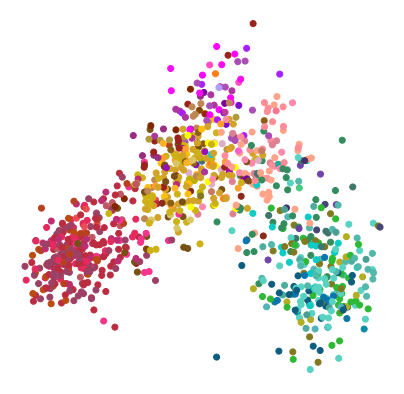

In [24]:
plt.figure(figsize=(7, 7))
plt.scatter((G @ w)[:, 0], (G @ w)[:, 1], c=colors)
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)

In [25]:
ttype_av_model_params_sRRR = np.array(
    [(G @ w @ v.T)[celltypes.values == ttype, :].mean(axis=0) for ttype in ttypes]
)
df_ttype_sRRR = pd.DataFrame(
    data=ttype_av_model_params_sRRR.T, index=model_param_names, columns=ttypes
)
df_ttype_sRRR

,Lamp5 Pax6,Lamp5 Egln3_1,Lamp5 Egln3_2,Lamp5 Pdlim5_1,Lamp5 Pdlim5_2,Lamp5 Slc35d3,Lamp5 Lhx6,Sncg Col14a1,Sncg Calb1_1,Sncg Calb1_2,...,L5 ET_4,L5/6 NP CT,L6 CT Cpa6,L6 CT Grp,L6 CT Pou3f2,L6b Col6a1,L6b Shisa6_1,L6b Shisa6_2,L6b Ror1,L5/6 NP_1
C,0.256659,0.421445,0.389478,0.701820,0.551144,0.469510,0.326909,0.369896,0.092020,0.314123,...,0.361154,0.563453,0.444834,0.332304,0.502251,0.624774,0.599340,0.734082,0.559716,0.608741
$R_{input}$,-0.210684,-0.318903,-0.296000,-0.543808,-0.420241,-0.339543,-0.250062,-0.319541,-0.113031,-0.237532,...,-0.167133,-0.405655,-0.282577,-0.249099,-0.324672,-0.394283,-0.409139,-0.459423,-0.369354,-0.411555
$\tau$,-0.294731,-0.314729,-0.298905,-0.603866,-0.431584,-0.252207,-0.260983,-0.524262,-0.340245,-0.233572,...,0.394385,-0.291249,0.005797,-0.233442,-0.028627,0.024402,-0.169954,0.052709,-0.079043,-0.147583
$g_{Nat}$,0.043946,0.157258,0.141283,0.221772,0.195599,0.224682,0.113509,0.013302,-0.102199,0.117720,...,0.468696,0.275381,0.335945,0.131397,0.361620,0.480014,0.363241,0.576082,0.379290,0.381528
$g_{Na}$,0.127359,0.114792,0.110571,0.235620,0.161266,0.073023,0.098436,0.239013,0.176423,0.084997,...,-0.271820,0.081267,-0.067248,0.082307,-0.056322,-0.103515,0.008488,-0.135025,-0.036488,-0.005336
$g_{Kd}$,-0.243306,-0.433511,-0.399012,-0.705893,-0.562906,-0.502719,-0.332883,-0.330668,-0.040117,-0.323319,...,-0.504879,-0.605601,-0.525457,-0.344774,-0.586215,-0.741276,-0.672262,-0.875795,-0.643819,-0.687834
$g_{M}$,-0.146237,-0.158296,-0.150181,-0.302173,-0.216682,-0.128761,-0.130937,-0.258869,-0.165859,-0.117497,...,0.185469,-0.149001,-0.003645,-0.117698,-0.021123,0.002743,-0.090870,0.014846,-0.046335,-0.080188
$g_{Kv31}$,-0.245166,-0.415663,-0.383513,-0.686023,-0.542036,-0.470682,-0.321121,-0.345637,-0.069756,-0.309892,...,-0.407566,-0.565742,-0.464875,-0.328884,-0.522158,-0.654180,-0.612593,-0.770492,-0.578254,-0.624137
$g_{L}$,-0.164287,-0.110427,-0.109628,-0.258986,-0.163239,-0.030357,-0.101523,-0.330452,-0.279766,-0.081355,...,0.530645,-0.025677,0.201683,-0.073212,0.194598,0.298575,0.104359,0.373445,0.172477,0.129569
$E_{leak}$,0.070986,0.063915,0.061571,0.131248,0.089806,0.040588,0.054821,0.133257,0.098425,0.047325,...,-0.151821,0.045156,-0.037684,0.045818,-0.031606,-0.057986,0.004528,-0.075609,-0.020558,-0.003190


In [26]:
family_av_model_params_sRRR = np.array(
    [
        (G @ w @ v.T)[family, :].mean(axis=0)
        for family in [
            celltype_Lamp5,
            celltype_Sncg,
            celltype_Vip,
            celltype_Sst,
            celltype_Pvalb,
            celltype_Pyr,
        ]
    ]
)
df_family_sRRR = pd.DataFrame(
    data=family_av_model_params_sRRR.T,
    index=model_param_names,
    columns=["Lamp5", "Sncg", "Vip", "Sst", "Pvalb", "Pyr"],
)
df_family_sRRR

,Lamp5,Sncg,Vip,Sst,Pvalb,Pyr
C,0.460288,0.316353,0.358483,0.046637,-0.693012,0.460595
$R_{input}$,-0.343798,-0.272067,-0.331088,-0.070645,0.467089,-0.246861
$\tau$,-0.315599,-0.440738,-0.642006,-0.256016,0.159013,0.292087
$g_{Nat}$,0.185901,0.015217,-0.054449,-0.093821,-0.438871,0.491705
$g_{Na}$,0.109687,0.200159,0.306290,0.136002,0.011092,-0.229106
$g_{Kd}$,-0.479117,-0.284337,-0.293568,-0.003546,0.784863,-0.601537
$g_{M}$,-0.159280,-0.217705,-0.315638,-0.124473,0.086937,0.134562
$g_{Kv31}$,-0.456150,-0.296196,-0.324615,-0.028889,0.711236,-0.503475
$g_{L}$,-0.094112,-0.275429,-0.446348,-0.220480,-0.155981,0.478192
$E_{leak}$,0.061053,0.111592,0.170807,0.075883,0.006431,-0.128018


In [27]:
def latent_space_genes_sRRR(X, vx, index, geneNames, alpha=0.5, axis=None):
    """
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    index: index in the 25 genes selected for the gene that you'd like to show
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    alpha: transparancy for contours (default = 0.5)
    ax: axis to plot one (default: None)

    Returns
    -------
    axis: figure objects; latent space with gene activation contours
    """
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

    # produces triangles from latent coordinates
    triang = tri.Triangulation((X @ vx)[:, 1], (X @ vx)[:, 0])

    # extract coordinates of eacht triangle
    x1 = (X @ vx)[:, 1][triang.triangles][:, 0]
    x2 = (X @ vx)[:, 1][triang.triangles][:, 1]
    x3 = (X @ vx)[:, 1][triang.triangles][:, 2]
    y1 = (X @ vx)[:, 0][triang.triangles][:, 0]
    y2 = (X @ vx)[:, 0][triang.triangles][:, 1]
    y3 = (X @ vx)[:, 0][triang.triangles][:, 2]

    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))

    # calculate edges
    edges = np.concatenate(
        (
            np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)[:, np.newaxis],
            np.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)[:, np.newaxis],
            np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2)[:, np.newaxis],
        ),
        axis=1,
    )

    # triangles with an edge longer than the 20th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(
        np.max(edges, axis=1)
        > np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-20]
    )
    ax.tricontourf(
        triang,
        X @ vx @ np.linalg.pinv(vx)[:, np.sum(vx, axis=1) != 0][:, index],
        cmap="inferno",
        levels=np.linspace(-1, 1, 40),
        extend="both",
    )
    ax.set_xlim([np.min((X @ vx)[:, 1]), np.max((X @ vx)[:, 1])])
    ax.set_ylim([np.min((X @ vx)[:, 0]), np.max((X @ vx)[:, 0])])
    # ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[np.sum(vx, axis=1) != 0][index], fontsize=12, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    return ax

In [28]:
def latent_space_ephys_sRRR(X, vx, vy, Y_column_index, features, alpha=1, axis=None):
    """
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)

    Returns
    -------
    ax: figure object, latent space with ephys activation contours
    """
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

    # produces triangles from latent coordinates
    triang = tri.Triangulation((X @ vx)[:, 1], (X @ vx)[:, 0])

    # extract coordinates of eacht triangle
    x1 = (X @ vx)[:, 1][triang.triangles][:, 0]
    x2 = (X @ vx)[:, 1][triang.triangles][:, 1]
    x3 = (X @ vx)[:, 1][triang.triangles][:, 2]
    y1 = (X @ vx)[:, 0][triang.triangles][:, 0]
    y2 = (X @ vx)[:, 0][triang.triangles][:, 1]
    y3 = (X @ vx)[:, 0][triang.triangles][:, 2]

    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))

    # calculate edges
    edges = np.concatenate(
        (
            np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)[:, np.newaxis],
            np.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)[:, np.newaxis],
            np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2)[:, np.newaxis],
        ),
        axis=1,
    )

    # triangles with an edge longer than the 20th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(
        np.max(edges, axis=1)
        > np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-20]
    )
    ax.tricontourf(
        triang,
        (X @ vx @ vy.T)[:, Y_column_index],
        cmap="inferno",
        levels=np.linspace(-1, 1, 40),
        extend="both",
    )

    ax.set_xlim([np.min((X @ vx)[:, 1]), np.max((X @ vx)[:, 1])])
    ax.set_ylim([np.min((X @ vx)[:, 0]), np.max((X @ vx)[:, 0])])
    # ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=12, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    return ax

We load cross-validation results using **sRRR** to predict maximum-a-posteriori estimates from ion channel and marker genes. Check `../code/deploy_sRRR_and_sBNN` for more.

In [41]:
with open(
    "data/sRRR/sRRR_vs_Bottleneck_rank2_CV_lasso_ion_channel_marker.pickle",
    "rb",
) as f:
    (
        r2_sRRR_rank2,
        r2_sRRR_relaxed_rank2,
        r2_sRRR_rank2_tr,
        r2_sRRR_relaxed_rank2_tr,
        nonzero_rank2,
        corrs_rank2,
        corrs_relaxed_rank2,
    ) = pickle.load(f)
with open(
    "data/sRRR/sRRR_vs_Bottleneck_rank13_CV_lasso_ion_channel_marker.pickle",
    "rb",
) as f:
    (
        r2_sRRR_rank13,
        r2_sRRR_relaxed_rank13,
        r2_sRRR_rank13_tr,
        r2_sRRR_relaxed_rank13_tr,
        nonzero_rank13,
        corrs_rank13,
        corrs_relaxed_rank13,
    ) = pickle.load(f)

# suppressing "mean of empty slice" warnings
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_13 = np.nanmean(nonzero_rank13, axis=0)[0, :]
    cr_13 = np.nanmean(r2_sRRR_relaxed_rank13, axis=0)[0, :]

In [42]:
sRRR_2_multivar_score = 1 - np.sum(
    (highest_posterior_samples_standardized - G @ w @ v.T) ** 2
) / np.sum(highest_posterior_samples_standardized**2)
sRRR_2_ind_score = np.array(
    [
        1
        - np.sum(
            (highest_posterior_samples_standardized[:, i] - (G @ w @ v.T)[:, i]) ** 2
        )
        / np.sum(highest_posterior_samples_standardized[:, i] ** 2)
        for i in range(len(model_param_names))
    ]
)

In [43]:
sRRR_2_multivar_score

0.19947051223227685

In [44]:
sRRR_2_ind_score

array([0.30010336, 0.13777083, 0.15004232, 0.16044094, 0.04418609,
       0.39485703, 0.03716772, 0.31855027, 0.14366406, 0.01379769,
       0.08727416, 0.18820378, 0.61705812])

In [45]:
n_2

array([77.7, 25.2, 14.9,  6.5,  5.1,  3.6,  3. ,  3. ,  2.8,  2. ,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [46]:
w.shape

(427, 2)

In [47]:
gene_names[w[:, 0] != 0]

array(['Cacna2d1', 'Cacna2d2', 'Cacng3', 'Gabra5', 'Gabrd', 'Gpm6a',
       'Grik1', 'Kcnab3', 'Kcnc1', 'Kcnc3', 'Kcnc4', 'Kcnip2', 'Kcnip3',
       'Kcnma1', 'Kcnv1', 'Lamp5', 'Lrrc38', 'Pex5l', 'Pvalb', 'Ryr1',
       'Scn1a', 'Scn3b', 'Slc17a7', 'Slc24a4', 'Vip'], dtype=object)

In [48]:
print(
    cr_2[np.isclose(n_2, 25, atol=3)][0],
    "+/-",
    np.nanstd(r2_sRRR_relaxed_rank2, axis=0)[0, :][np.isclose(n_2, 25, atol=3)][0],
)

0.17037856609537325 +/- 0.026022065525568395


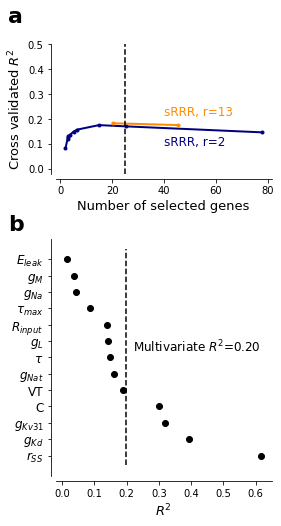

In [72]:
fig = plt.figure(figsize=(3,6))
ax_sRRR_cv = plt.axes([0,.7,1,.3])
ax_sRRR_pred = plt.axes([0,0,1,.55])

ax_sRRR_cv.plot(n_2, cr_2, ".-", linewidth=2, color="navy")
ax_sRRR_cv.plot(n_13[1:], cr_13[1:], ".-", linewidth=2, color="darkorange")
ax_sRRR_cv.set_ylim([-0.02, 0.5])
ax_sRRR_cv.set_xlabel("Number of selected genes", fontsize=13)
ax_sRRR_cv.set_ylabel(r"Cross validated $R^2$", fontsize=13)
ax_sRRR_cv.vlines(
    x=25,
    ymin=ax_sRRR_cv.get_ylim()[0],
    ymax=ax_sRRR_cv.get_ylim()[1],
    linestyles="dashed",
    color="black",
)
ax_sRRR_cv.annotate(
    "sRRR, r=13", (40, np.max(cr_13) + 0.03), fontsize=12, color="darkorange"
)
ax_sRRR_cv.annotate("sRRR, r=2", (40, np.max(cr_2) - 0.08), fontsize=12, color="navy")

adjust_spines(ax_sRRR_cv, ["bottom", "left"])

order = np.argsort(sRRR_2_ind_score)[::-1]
ax_sRRR_pred.scatter(
    sRRR_2_ind_score[order], range(len(model_param_names)), color="black"
)
ax_sRRR_pred.vlines(
    sRRR_2_multivar_score,
    ymin=ax_sRRR_pred.get_ylim()[0],
    ymax=ax_sRRR_pred.get_ylim()[1],
    linestyle="dashed",
    color="black",
)
ax_sRRR_pred.annotate(
    r"Multivariate $R^2$={0:.2f}".format(sRRR_2_multivar_score),
    (   sRRR_2_multivar_score + 0.02,
        ax_sRRR_pred.get_ylim()[0]
        + 1.05 * (ax_sRRR_pred.get_ylim()[1] - ax_sRRR_pred.get_ylim()[0]) / 2,
    ),
    fontsize=12,
)
ax_sRRR_pred.set_xlim([-0.02, 0.65])
ax_sRRR_pred.set_xlabel(r"$R^2$", fontsize=13)
ax_sRRR_pred.set_yticks(range(len(model_param_names)))
adjust_spines(ax_sRRR_pred, ["bottom", "left"])
ax_sRRR_pred.set_yticklabels(model_param_names[order], fontsize=12);

fig.text(-0.22, 1.05, "a", fontsize=22, fontweight="bold")
fig.text(-0.22, 0.57, "b", fontsize=22, fontweight="bold")

plt.savefig("figures/bridge_results.pdf", bbox_inches="tight", pad_inches=0)

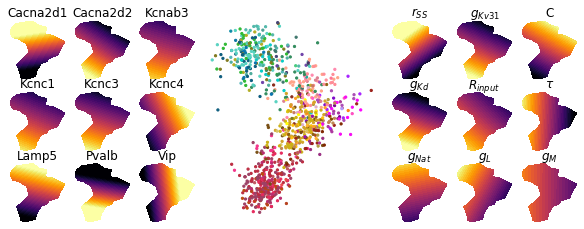

In [82]:
fig = plt.figure(figsize=(9,3))

width, height = .085, .27

ax_sRRR_latent = plt.axes([0.3, 0, 0.27, .966])
ax_sRRR_genes = np.array(
    [
        [plt.axes([x, y, width, height]) for x in [0, 0.1, 0.2]]
        for y in [0.66, 0.33, 0]
    ]
)
ax_sRRR_model_params = np.array(
    [
        [plt.axes([0.59 + x, y, width, height]) for x in [0, 0.1, 0.2]]
        for y in [0.66, 0.33, 0]
    ]
)

ax_sRRR_latent.scatter((G @ w)[:, 1], (G @ w)[:, 0], s=5, c=colors)
ax_sRRR_latent.set_xticks([])
ax_sRRR_latent.set_yticks([])
sns.despine(ax=ax_sRRR_latent, left=True, bottom=True)

gene_indices_for_visualization = [0, 1, 7, 8, 9, 10, 15, 18, 24]

for i, ax in enumerate(ax_sRRR_genes.reshape(-1)):
    latent_space_genes_sRRR(
        G, w, gene_indices_for_visualization[i], gene_names, axis=ax
    )
    sns.despine(ax=ax, left=True, bottom=True)

model_param_names_indices_for_visualization = [-1, 7, 0, 5, 1, 2, 3, 8, 6]

for i, ax in enumerate(ax_sRRR_model_params.reshape(-1)):
    latent_space_ephys_sRRR(
        G,
        w,
        v,
        model_param_names_indices_for_visualization[i],
        model_param_names,
        axis=ax,
    )
    sns.despine(ax=ax, left=True, bottom=True)
    
plt.savefig("figures/bridge_embed_1.pdf", bbox_inches="tight", pad_inches=0)

In [78]:
def create_figure_5(fig):
    if fig is None:
        fig = plt.figure(figsize=(12, 5))
    else:
        fig = fig

    ax_df_npen_fam = plt.axes([0.05, 0.5, 0.08, 0.45])
    ax_df_npen_ttype = plt.axes([0.15, 0.5, 0.85, 0.45])
    ax_df_sRRR_fam = plt.axes([0.05, 0, 0.08, 0.45])
    ax_df_sRRR_ttype = plt.axes([0.15, 0, 0.85, 0.45])

    return ax_df_npen_fam, ax_df_npen_ttype, ax_df_sRRR_fam, ax_df_sRRR_ttype

Let us insert spaces between cell types.

In [79]:
df_type_c = df_type.copy()
df_ttype_sRRR_c = df_ttype_sRRR.copy()
spots_to_insert_blanks = [7, 12, 24, 43, 53]
for i in [7, 12, 24, 43, 53]:
    df_type_c.insert(i, i, 0)
    df_ttype_sRRR_c.insert(i, i, 0)
mask = np.zeros_like(df_type_c.values, dtype=bool)
mask[:, spots_to_insert_blanks] = True

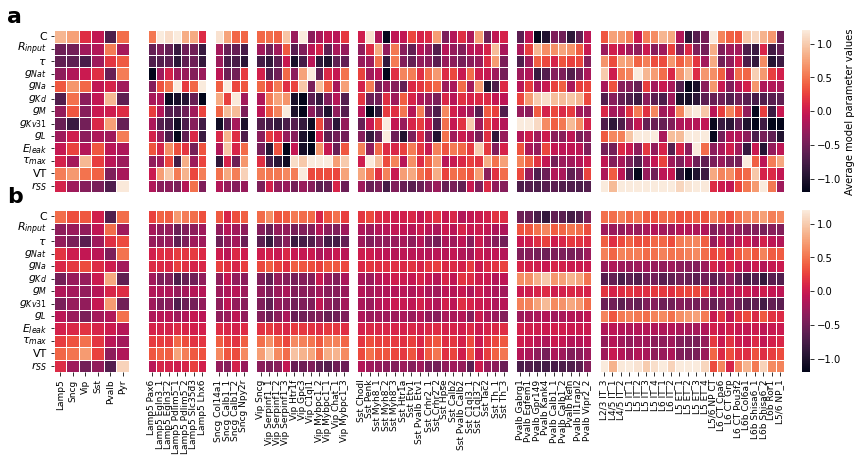

In [81]:
fig = plt.figure(figsize=(13, 5))

ax_df_npen_fam, ax_df_npen_ttype, ax_df_sRRR_fam, ax_df_sRRR_ttype = create_figure_5(
    fig
)

sns.heatmap(
    df_family,
    xticklabels=True,
    yticklabels=model_param_names,
    linewidth=0.5,
    vmin=-1.2,
    vmax=1.2,
    cbar=False,
    ax=ax_df_npen_fam,
)
sns.heatmap(
    df_type_c,
    mask=mask,
    xticklabels=True,
    linewidth=0.5,
    yticklabels=[],
    vmin=-1.2,
    vmax=1.2,
    ax=ax_df_npen_ttype,
    cbar_kws={"label": "Average model parameter from genes", "anchor": (-0.2, 0.5)},
)
ax_df_npen_ttype.set_xticks([])
ax_df_npen_fam.set_xticks([])
ax_df_npen_fam.set_yticks(
    [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5]
)
ax_df_npen_fam.set_yticklabels(model_param_names, fontsize=11)
ax_df_npen_ttype.collections[0].colorbar.set_label(
    "Average model parameter values", fontsize=10
)

sns.heatmap(
    df_family_sRRR,
    xticklabels=True,
    linewidth=0.5,
    yticklabels=model_param_names,
    vmin=-1.2,
    vmax=1.2,
    cbar=False,
    ax=ax_df_sRRR_fam,
)
sns.heatmap(
    df_ttype_sRRR_c,
    mask=mask,
    xticklabels=True,
    linewidth=0.5,
    yticklabels=[],
    vmin=-1.2,
    vmax=1.2,
    ax=ax_df_sRRR_ttype,
    cbar_kws={"anchor": (-0.2, 0.5)},
)
ax_df_sRRR_fam.set_xticklabels(
    ax_df_sRRR_fam.get_xticklabels(), fontsize=9, rotation=90
)
ax_df_sRRR_ttype.set_xticklabels(
    ax_df_sRRR_ttype.get_xticklabels(), fontsize=9, rotation=90
)
ax_df_sRRR_fam.set_yticks(
    [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5]
)
ax_df_sRRR_fam.set_yticklabels(model_param_names, fontsize=11)
ax_df_sRRR_ttype.set_xticks(
    np.delete(ax_df_sRRR_ttype.get_xticks(), [7, 12, 24, 43, 53])
)

fig.text(0, 0.97, "a", fontsize=22, fontweight="bold")
fig.text(0, 0.47, "b", fontsize=22, fontweight="bold")

plt.savefig("figures/bridge_predict.pdf", bbox_inches="tight", pad_inches=0)